## Configuration

### Imports

In [18]:
# Utilities
from IPython.display import display
import os
import numpy as np
import time
import pandas as pd
from fastprogress import master_bar, progress_bar

# MongoDB functionality
from pymongo import MongoClient, InsertOne, UpdateOne
from bson import ObjectId
from collections.abc import MutableMapping

# Graphics
import matplotlib.pyplot as plt
from matplotlib.pyplot import text
import seaborn as sns
sns.set(font_scale=0.9)
sns.set_style("whitegrid")
sns.set_style({'font.family':'monospace'})


# Network analysis
import networkx as nx
import graph_tool.all as gt

ROOT_DIR = "/home/mattia/javier/botbusters-spanish-general-elections-network-analysis/"

# Change path to root
os.chdir(ROOT_DIR)

# MongoDB parameters
mongoclient = MongoClient('localhost', 27017)
db = mongoclient.influence

In [3]:
sns.__version__

'0.11.0'

### Support Functions

In [4]:
def flatten(d, parent_key='', sep='_'):
    """Formats MongoDB results
    
    Keyword arguments:
    d -- dictionary with key and uncleaned values
    parent_key --
    sep --
    """
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, MutableMapping):
            items.extend(flatten(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

def make_objid(text):
    """Makes an ObjectId of 4 bytes
    
    Keyword arguments:
    text -- string to be converted into Object ID
    """
    text = str(text)
    if not text.strip():
        return None
    try:
        return ObjectId(text.rjust(24,"0"))
    except Exception as ex:
        print(text, ex)
        return None
    
def get_tweets(collection):
    """
    Gets tweets
    
    collection - Tweets MongoDB collection
    """
    tweets = list(collection
                    .find({'sampled':True},{'_id': False, 'tweet_id': True, 'user_id' : True})
                   )
    
    print("Number of tweets:", len(tweets))
    tweets = [flatten(t) for t in tweets]
    df_tweets = pd.DataFrame(tweets)
    df_tweets.user_id = df_tweets.user_id.apply(lambda t : str(t))
    df_tweets.user_id = df_tweets.user_id.astype(str)
    df_tweets.rename(columns={'user_id':'tweet_author'},inplace=True)
    return df_tweets
    
    
def get_retweets(collection):
    """
    Gets retweets
    
    collection - Retweets MongoDB collection
    """
    retweets = list(collection
                    .find({'sampled':True},{'_id': False, 'tweet_id': True, 'user_id' : True})
                   )
    
    print("Number of retweets:", len(retweets))
    retweets = [flatten(r) for r in retweets]
    df_retweets = pd.DataFrame(retweets)
    df_retweets.user_id = df_retweets.user_id.apply(lambda t : str(t))
    df_retweets.user_id = df_retweets.user_id.astype(str)
    df_retweets.rename(columns={'user_id':'retweet_author'},inplace=True)
    return df_retweets

def get_users(collection):
    """
    Gets users
    
    collection - Users MongoDB collection
    """
    users = list(collection.find({ '$and' : [ { 'sampled': True } , { 'botscore' : { '$gte' : 0 } }]},
                                 {'_id' : True, 'botscore' : True})
                )
    print("Number of sampled users with botscore in DB:", len(users))
    users = [flatten(u) for u in users]
    df_users = pd.DataFrame(users)
    df_users._id = df_users._id.apply(lambda t : str(t))
    df_users._id = df_users._id.astype(str)
    return df_users

## Data preparation

#### Getting tweets from DB...

In [5]:
df_tweets = get_tweets(db.tweets)
df_tweets.head(3)

Number of tweets: 358190


,tweet_author,tweet_id
0,000000000000000279465279,000001191464087064109058
1,000000000000001266667238,000001192787272975945729
2,000000000000000331220696,000001191467194519080960


In [6]:
df_tweets[df_tweets.duplicated()].count()
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358190 entries, 0 to 358189
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   tweet_author  358190 non-null  object
 1   tweet_id      358190 non-null  object
dtypes: object(2)
memory usage: 5.5+ MB


In [7]:
df_tweets.drop_duplicates(keep='first', inplace=True)

#### Getting retweets from DB...

In [8]:
df_retweets = get_retweets(db.retweets)
df_retweets.head(3)

Number of retweets: 7868861


,tweet_id,retweet_author
0,000001193667913368121351,000000000000004460826197
1,000001192581634291355649,000001075150211725619200
2,000001190659978471911424,000000000000000071190801


In [9]:
df_retweets[df_retweets.duplicated()].count()

tweet_id          3525
retweet_author    3525
dtype: int64

In [10]:
df_retweets.drop_duplicates(keep='first', inplace=True)
df_retweets.count()

tweet_id          7865336
retweet_author    7865336
dtype: int64

#### Getting users form DB

In [11]:
users = get_users(db.users)
display(users.head(5))

Number of sampled users with botscore in DB: 1150709


,_id,botscore
0,000000000000002266588688,0.16
1,000000000000000471028961,0.03
2,000000000000002792368467,0.11
3,000000000000004068857357,0.01
4,000000000000000006953012,0.03


#### Build directed-weighted retweet graph

In [12]:
df_edges = df_retweets.set_index('tweet_id').join(df_tweets.set_index('tweet_id')).reset_index(drop=True)
df_edges.head(5)

,retweet_author,tweet_author
0,000001041608534734061568,000000000000000068740712
1,000000000000002824508322,000000000000000068740712
2,000000755192640321314817,000000000000000068740712
3,000000000000000523370717,000000000000000068740712
4,000000000000003610966882,000000000000000068740712


In [13]:
df_edges = df_edges.groupby(['retweet_author','tweet_author']).size().reset_index().rename(columns={0:'weight'})
df_edges.head(5)

,retweet_author,tweet_author,weight
0,000000000000000000002862,000000000000000026994875,1
1,000000000000000000003065,000000000000000016409683,1
2,000000000000000000003065,000000000000000121385551,1
3,000000000000000000003065,000000000000000207741909,1
4,000000000000000000003968,000000000000000014436030,1


In [14]:
implicated_users = []
implicated_users = list(set(list(df_edges.retweet_author.unique()) + list(df_edges.tweet_author.unique())))
#print("Implicated users:", len(implicated_users))

df_users = users[users._id.isin(implicated_users)]
print("Users with botscore:", len(df_users))

print("Retweets without botscore:", len(df_edges))
df_edges = df_edges[(df_edges.retweet_author.isin(df_users._id)) & (df_edges.tweet_author.isin(df_users._id))]
print("Retweets with botscore:", len(df_edges))

Users with botscore: 1150709
Retweets without botscore: 6037031
Retweets with botscore: 4313219


### Using networkx

In [14]:
G = nx.from_pandas_edgelist(df=df_edges, source='tweet_author', target='retweet_author', edge_attr='weight', create_using=nx.DiGraph)
node_attr = df_users.set_index('_id').to_dict('index')
nx.set_node_attributes(G, node_attr)

### Using graph-tool

In [52]:
%%time

X = gt.Graph(directed=True)
eweight = X.new_edge_property('int')
user_ids = X.add_edge_list(df_edges.values, hashed=True, hash_type='string', eprops=[eweight])

CPU times: user 17 s, sys: 689 ms, total: 17.7 s
Wall time: 17.5 s


In [20]:
%%time

# botscore for nodes
user_botscores_dic = df_users.set_index('_id').to_dict('index')
node_botscores = []
for user_id in user_ids:
    node_botscore = user_botscores_dic[user_id]['botscore']
    node_botscores.append(node_botscore)

CPU times: user 6.02 s, sys: 252 ms, total: 6.27 s
Wall time: 6.27 s


In [21]:
%%time
vbotscores = X.new_vertex_property(value_type='float', vals=node_botscores)

CPU times: user 266 ms, sys: 0 ns, total: 266 ms
Wall time: 263 ms


In [25]:
INITIAL_NODES = X.num_vertices()
INITIAL_WEIGHTS = np.sum(X.get_in_degrees(vs=X.get_vertices(),eweight=eweight))
INITIAL_GIANT_NODES = gt.extract_largest_component(g=X, directed=True).num_vertices()
print(INITIAL_NODES,INITIAL_WEIGHTS,INITIAL_GIANT_NODES)

1027305 5686961 20061


## 1. Network robutness

#### Relationship botscore/random vs % of METRICS

In [57]:
%%time

data = {'weights': [0,0],
    'giant nodes': [0,0],
    'nodes' : [0,0],
    'percentile':[0,0],
    'mode':['descending botscore', 'random']
}

prs = list(range(10,110,10))
ps = np.percentile(a=users.index, q=prs)
percentile = dict(zip(prs,ps))
print(percentile)


INITIAL_NODES = X.num_vertices()
INITIAL_WEIGHTS = np.sum(X.get_in_degrees(vs=X.get_vertices(),eweight=eweight))
INITIAL_GIANT_NODES = gt.extract_largest_component(g=X, directed=True).num_vertices()


for mode in ['descending botscore', 'random']:

    if mode == 'descending botscore':
        subset_users = users.sort_values(by='botscore',axis='index',ascending=False)
    else:
        subset_users = users.sample(frac=1,random_state=30100).reset_index(drop=True)

    display(subset_users.info())
    
    for percentage in progress_bar(prs):

        perc = int(percentile[percentage])-1
        nodes = set(subset_users.head(perc)['_id'])
        
        filtering_properties = []
        for u in user_ids:
            if u in nodes:
                filtering_properties.append(True)
            else:
                filtering_properties.append(False)
        
        X.set_vertex_filter(X.new_vertex_property(value_type='bool', vals=filtering_properties))

        total_weights = np.sum(X.get_in_degrees(vs=X.get_vertices(),eweight=eweight))/INITIAL_WEIGHTS
        total_nodes = X.num_vertices()/INITIAL_NODES
        try:
            total_giant = gt.extract_largest_component(g=X, directed=True).num_vertices() / INITIAL_GIANT_NODES
        except ValueError:
            total_giant = 0

        data['weights'].append(total_weights)
        data['nodes'].append(total_nodes)
        #data['edges'].append(total_edges)
        data['percentile'].append(percentage)
        data['giant nodes'].append(total_giant)
        data['mode'].append(mode)
        
        X.set_vertex_filter(None)

{10: 115070.8, 20: 230141.6, 30: 345212.39999999997, 40: 460283.2, 50: 575354.0, 60: 690424.7999999999, 70: 805495.6, 80: 920566.4, 90: 1035637.2000000001, 100: 1150708.0}
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1150709 entries, 908938 to 380276
Data columns (total 2 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   _id       1150709 non-null  object 
 1   botscore  1150709 non-null  float64
dtypes: float64(1), object(1)
memory usage: 26.3+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1150709 entries, 0 to 1150708
Data columns (total 2 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   _id       1150709 non-null  object 
 1   botscore  1150709 non-null  float64
dtypes: float64(1), object(1)
memory usage: 17.6+ MB


None

CPU times: user 1min 4s, sys: 396 ms, total: 1min 4s
Wall time: 1min 4s


In [58]:
df= pd.DataFrame.from_dict(data,orient='columns')
df.head()

,weights,giant nodes,nodes,percentile,mode
0,0.000000,0.000000,0.000000,0,descending botscore
1,0.000000,0.000000,0.000000,0,random
2,0.004267,0.005483,0.099861,10,descending botscore
3,0.019902,0.043168,0.200648,20,descending botscore
4,0.059858,0.097453,0.301671,30,descending botscore


In [59]:
pd.melt(df,['percentile','mode']).sort_values(by='percentile', ascending=False, ignore_index=True).head()

,percentile,mode,variable,value
0,100,descending botscore,giant nodes,1.000000
1,100,descending botscore,weights,0.999999
2,100,descending botscore,nodes,0.999999
3,100,random,giant nodes,1.000000
4,100,random,weights,1.000000


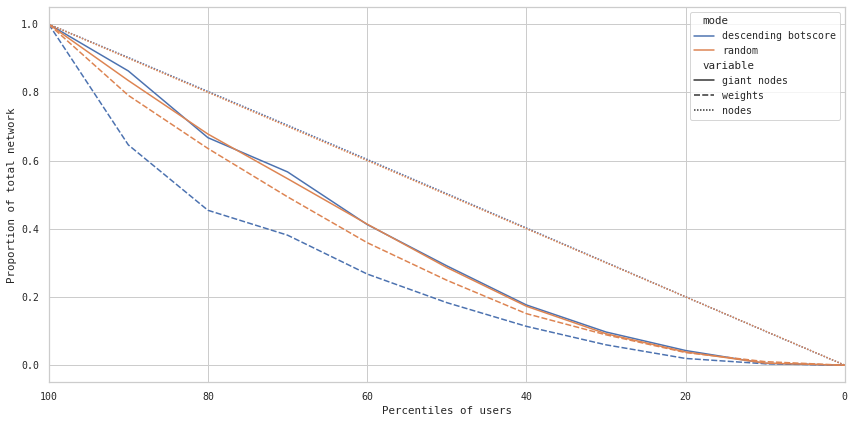

In [61]:
fig, axs = plt.subplots(1, 1, figsize=(12,6))

ax = sns.lineplot(x='percentile',
                  y='value',
                  style='variable',
                  hue='mode',
                  data=pd.melt(df,['percentile','mode']).sort_values(by='percentile', ascending=False, ignore_index=True),
                  sort=False)

# Put the legend out of the figure
ax.set_ylabel(ylabel='Proportion of total network')
ax.set_xlabel(xlabel='Percentiles of users')
ax.set_xlim(100,0)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout()
plt.savefig("images/robutness.svg")